# Box model of the subglacial plume at the 79° North Glacier

Original author: Otis Hoffmann (2021)

Modified by Markus Reinert (2022)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean  # colormaps for oceanography

## Constants and Settings

In [2]:
s_yr = 3600 * 24 * 365.2425  # factor to convert from seconds to years

### Thermodynamics

Parameters from Jenkins (2011).

In [3]:
c_i = 2009  # specific heat capacity for ice
c_p = 3974  # specific heat capacity for sea water
L = 3.35e5  # latent heat of fusion

y1 = -0.0573
y2 = 0.0832
y3 = 7.61e-4

def freeze(S, z):
    """Compute freezing point temperature from salinity S and vertical coordinate z.

    This function implements an empirical, linearized equation for the temperature of sea water at the freezing point.
    The parameter z is measured from the sea level with negative values downward.
    """
    return y1 * S + y2 + y3 * z

### Glacier ice

In [4]:
z_g = -600  # vertical position of the grounding line
l = 80_000  # length of the ice tongue
w = 20_000  # width of the ice tongue
T_i = -20  # temperature of glacier ice

A = w * l  # area of the ice-ocean interface

sin_alpha = np.sin(np.arctan(np.abs(z_g) / l))  # sine of the ice slope angle

# We assume that the water discharged at the grounding line is freshwater at the local freezing point
T_g = freeze(S=0, z=z_g)  # temperature of the subglacial discharge

### Plume properties

In [5]:
u = 0.2  # velocity
h = 10  # thickness

V = A * h  # volume

### Entrainment

Parameters from Jenkins (2011).

In [6]:
E_0 = 3.6e-2  # entrainment coefficient
v_e = E_0 * u * sin_alpha  # entrainment velocity
Q_a = v_e * A  # entrainment transport

### Exchange velocities

Parameters from Jenkins (2011).

In [7]:
# Stanton numbers for temperature and salinity
St_T = 1.1e-3
St_S = 3.1e-5

# Exchange velocities for temperature and salinity
gamma_T = St_T * u
gamma_S = St_S * u

## Basal Melting

In [8]:
def basalmelting(S, T, z_b):
    """Calculate melt rate and boundary layer properties for given plume properties.
    
    Input parameters:
    S, T: plume salinity and temperature
    z_b: vertical position of the ice–ocean interface

    Return values (in a dictionary):
    S_b, T_b: boundary layer salinity and temperature
    v_b: melt rate in m/s
    meltrate: melt rate in m/yr
    """
    a = y1 * (gamma_T - gamma_S * c_i/c_p)
    b = gamma_T * (y2 + y3 * z_b - T) + gamma_S / c_p * (c_i * (y1 * S - y2 - y3 * z_b + T_i) - L)
    c = (gamma_S * S) / c_p * (c_i * (y3 * z_b - T_i) + L)
    S_b = - (b + np.sqrt(b ** 2 - 4 * a * c)) / (2 * a)
    T_b = y1 * S_b + y2 + y3 * z_b
    v_b = (gamma_S * (S - S_b)) / S_b
    return {
        "S_b": S_b,
        "T_b": T_b,
        "v_b": v_b,
        "meltrate": v_b * s_yr,
    }

In [9]:
basalmelting(30, -1.5, -300)

{'S_b': 27.608378181857734,
 'T_b': -1.7270600698204481,
 'v_b': 5.370853432537372e-07,
 'meltrate': 16.94877639696171}

(0.0, 101.01688772602597)

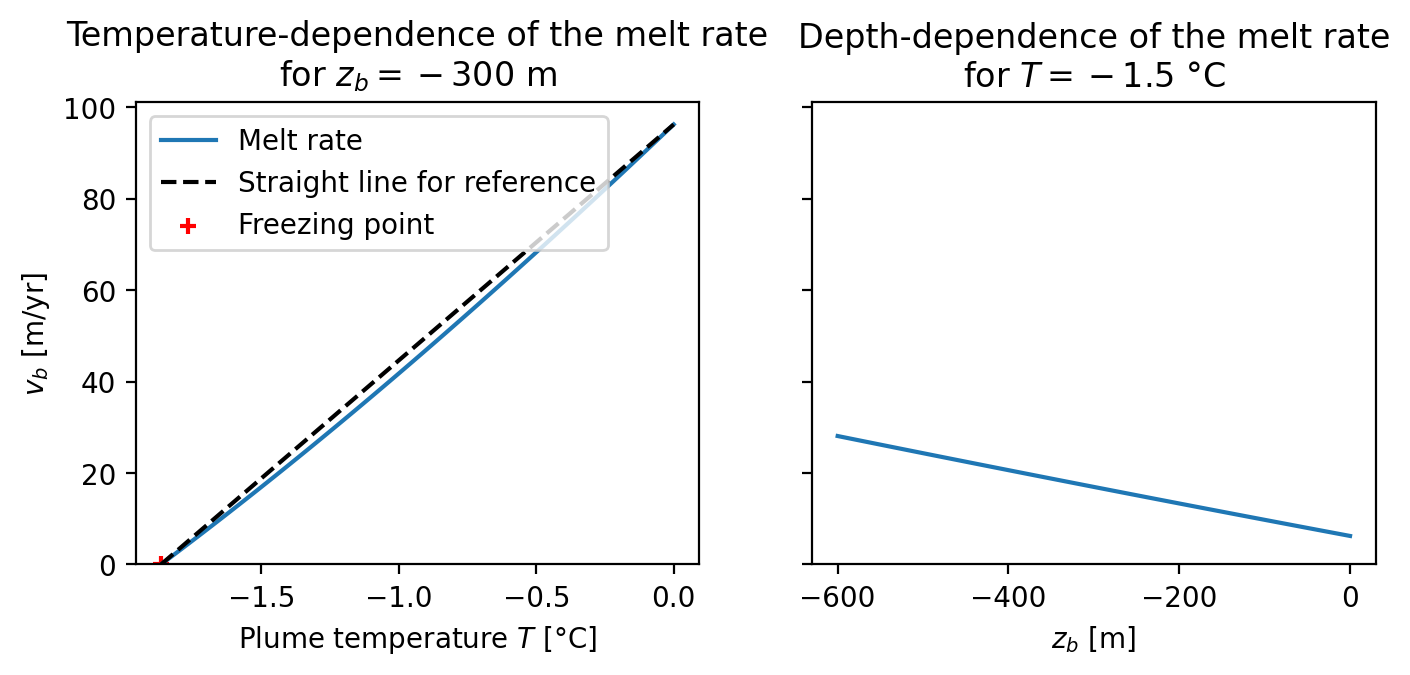

In [10]:
fig, axs = plt.subplots(ncols=2, figsize=(8, 3), dpi=200, sharey=True)

ax = axs[0]
S = 30
T_max = 0
z_b = -300
T_fr = freeze(S, z_b)
T = np.linspace(T_fr, T_max, 100)
ax.set_title(f"Temperature-dependence of the melt rate\nfor $z_b={z_b}$ m")
ax.set_xlabel('Plume temperature $T$ [°C]')
ax.set_ylabel('$v_b$ [m/yr]')
ax.plot(T, basalmelting(S, T, z_b)["meltrate"], label='Melt rate')
x = [T_fr, T_max]
y = [basalmelting(S, T_fr, z_b)["meltrate"], basalmelting(S, T_max, z_b)["meltrate"]]
ax.plot(x, y, "k--", label='Straight line for reference')
ax.scatter(T_fr, basalmelting(S, T_fr, z_b)["meltrate"], marker='+', c='red', label='Freezing point')
ax.legend()

ax = axs[1]
T = -1.5
z_bot = -600
z_top = 0
z_b = np.linspace(z_bot, z_top, 100)
ax.set_title(f"Depth-dependence of the melt rate\nfor $T={T}$ °C")
ax.set_xlabel('$z_b$ [m]')
ax.plot(z_b, basalmelting(S, T, z_b)["meltrate"])
ax.set_ylim(0)

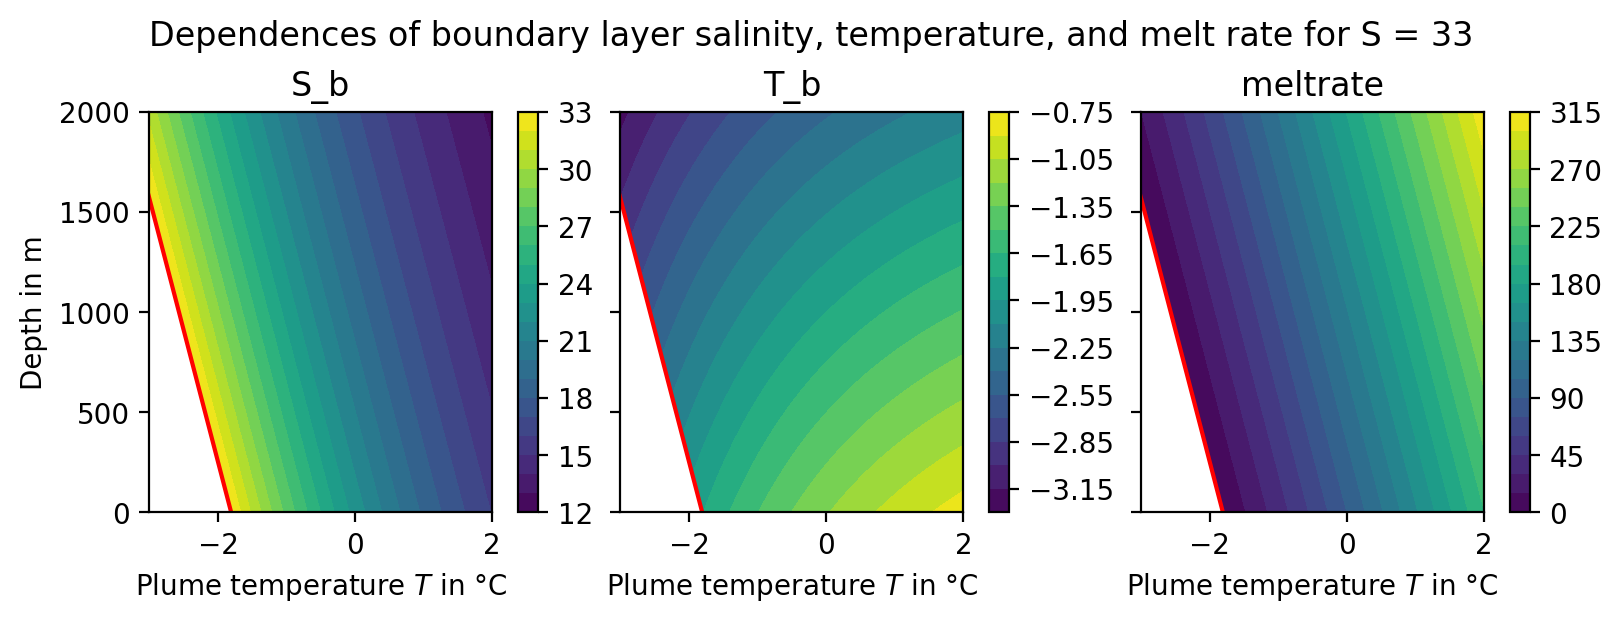

In [11]:
S = 33
T_range = np.linspace(-3, 2, 500)
z_range = np.linspace(-2000, 0, 1000)

result = basalmelting(S, T_range[np.newaxis, :], z_range[:, np.newaxis])

TT, ZZ = np.meshgrid(T_range, z_range)

fig, axs = plt.subplots(ncols=3, figsize=(8, 3), dpi=200, sharey=True, sharex=True, constrained_layout=True)
fig.suptitle("Dependences of boundary layer salinity, temperature, and melt rate for S = 33")
axs[0].set_ylabel("Depth in m")
for ax, var in zip(axs, ["S_b", "T_b", "meltrate"]):
    ax.set_title(var)
    data = np.where(TT >= freeze(S, ZZ), result[var], np.nan)
    im = ax.contourf(TT, -ZZ, data, levels=20)
    fig.colorbar(im, ax=ax)
    ax.plot(freeze(S, z_range), -z_range, "r")
    ax.set_xlim(T_range.min(), T_range.max())
    ax.set_xlabel("Plume temperature $T$ in °C")

Compare the above figure with Fig. 2 of Olbers & Hellmer (2010).

## The Box Model

Timestep $\Delta t$ and number of iterations $N$ determine the accuracy and computation time of the model.

In [12]:
dt = 3600
N = 720

time = np.arange(N) * dt / (60 * 60 * 24)  # time in days

In [13]:
def boxmodel(S_a, T_a, Q_g, z_b):
    """Calculate melt rate and plume properties for given environmental conditions.
    
    Input parameters:
    S_a, T_a: ambient salinity and temperature
    Q_g: subglacial discharge
    z_b: vertical position of the ice–ocean interface

    Return values (time series in a dictionary):
    v_b: melt rate in m/yr
    S, T: plume salinity and temperature
    S_b, T_b: boundary layer salinity and temperature
    Q_m: melt volume rate in m³/s
    Q_out: outflow of glacially modified water
    """

    v_b_n = np.zeros(N)
    S_n = np.zeros(N)
    T_n = np.zeros(N)
    S_b_n = np.zeros(N)
    T_b_n = np.zeros(N)
    Q_m_n = np.zeros(N)
    Q_out_n = np.zeros(N)

    # Set the initial values of plume salinity and temperature
    S = 30
    T = freeze(S, z_b)

    for i in range(N):
        # Compute the response of the melt layer
        bmelt = basalmelting(S, T, z_b)
        S_b = bmelt["S_b"]
        T_b = bmelt["T_b"]
        v_b = bmelt["v_b"]
        Q_m = v_b * A
        
        # Update the plume parameters
        Q = - (Q_g + Q_m + Q_a)
        S = (Q_a * S_a + V/dt * S) / (V/dt - Q)
        T = (Q_a * T_a + Q_g * T_g + (Q_m + A * gamma_T) * T_b + V/dt * T) / (V/dt - Q + A * gamma_T)

        v_b_n[i] = v_b
        S_n[i] = S
        T_n[i] = T
        S_b_n[i] = S_b
        T_b_n[i] = T_b
        Q_m_n[i] = Q_m
        Q_out_n[i] = Q

    return {
        "v_b": v_b_n * s_yr,
        "S": S_n,
        "T": T_n,
        "S_b": S_b_n,
        "T_b": T_b_n,
        "Q_m": Q_m_n,
        "Q_out": Q_out_n,
    }

### Application of the model

Final values and relative change in last time step:
v_b   =      13.28 (-3e-10)
S     =      32.72 ( 1e-09)
T     =      -1.72 ( 1e-09)
S_b   =      30.64 ( 1e-09)
T_b   =      -1.90 ( 1e-09)
Q_m   =     673.21 (-3e-10)
Q_out =  -87140.78 (-2e-12)
Percentage of basal melting in total fresh water export: 90.6 %


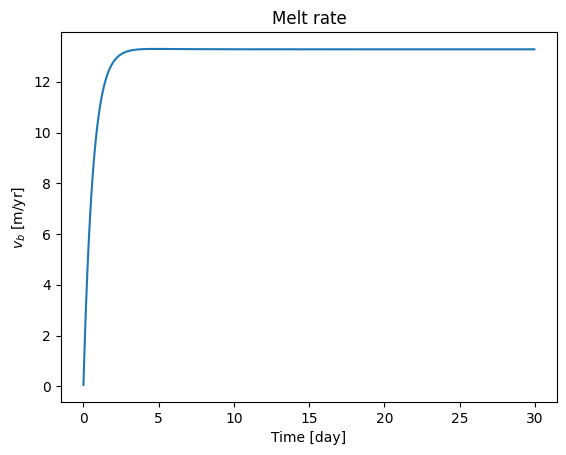

In [14]:
S_a = 33
T_a = -1
Q_g = 70
z_b = z_g / 2  # average depth of the plume is halfway between grounding line and sea level
result = boxmodel(S_a, T_a, Q_g, z_b)

print("Final values and relative change in last time step:")
for v in result:
    final_value = result[v][-1]
    last_change = result[v][-1] - result[v][-2]
    print(f"{v:5} = {final_value:10.2f} ({last_change / final_value:6.0e})")

print(f"Percentage of basal melting in total fresh water export: {result['Q_m'][-1] / (Q_g + result['Q_m'][-1]) * 100:.1f} %")

plt.title("Melt rate")
plt.xlabel("Time [day]")
plt.ylabel("$v_b$ [m/yr]")
plt.plot(time, result["v_b"])

### Comparison with other scenarios

In [13]:
future = boxmodel(35, 0, 70, -300)
adaptedQ_g = boxmodel(35, 0, 144.8, -300)

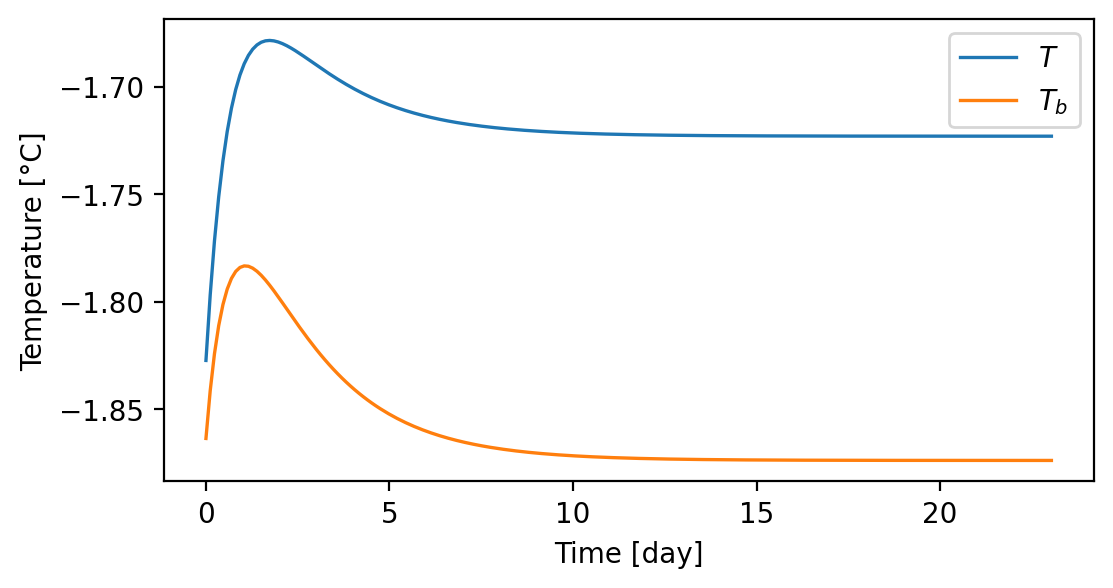

In [14]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['T'], linewidth=1.2, label = '$T$')
plt.plot(time, future['T_b'], linewidth=1.2, label = '$T_b$')
plt.xlabel('Time [day]')
plt.ylabel('Temperature [°C]')
plt.legend()

Of special interest here are the melt rate in meters per year, as well as the ratio between transport from melting and transport from subglacial discharge. Both are shown below, with the time axis in days to get a better idea of the time scales. Added aswell are two other scenarios to show different outcomes for different environmental parameters.

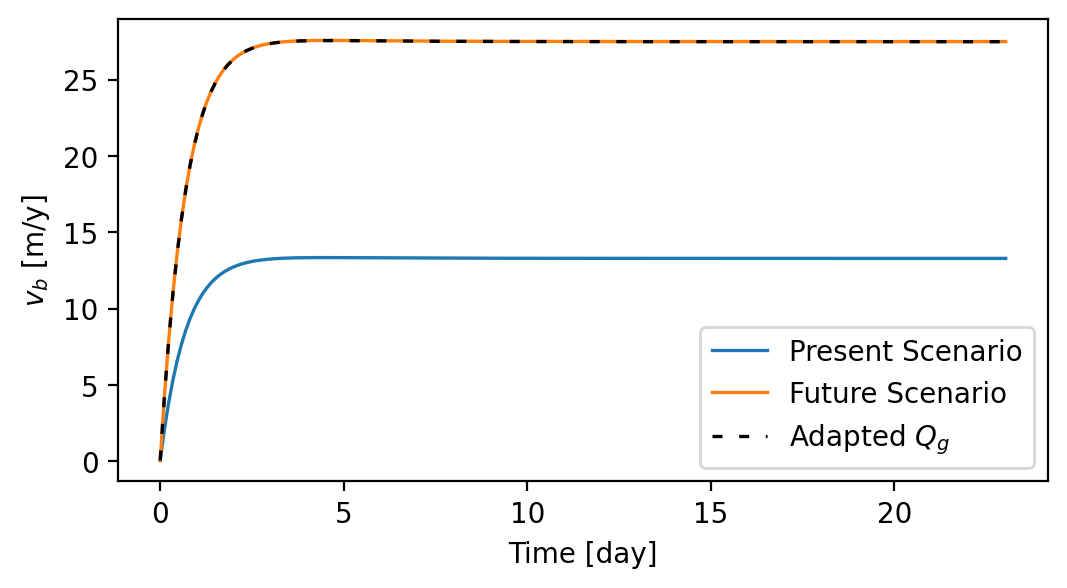

In [15]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['v_b'], linewidth=1.2, label = 'Present Scenario')
plt.plot(time, future['v_b'], linewidth=1.2, label = 'Future Scenario')
plt.plot(time, adaptedQ_g['v_b'], linewidth=1.2, label = 'Adapted $Q_g$', c = "k", linestyle =  (0, (3, 5)))
plt.xlabel('Time [day]')
plt.ylabel('$v_b$ [m/y]')
plt.legend()

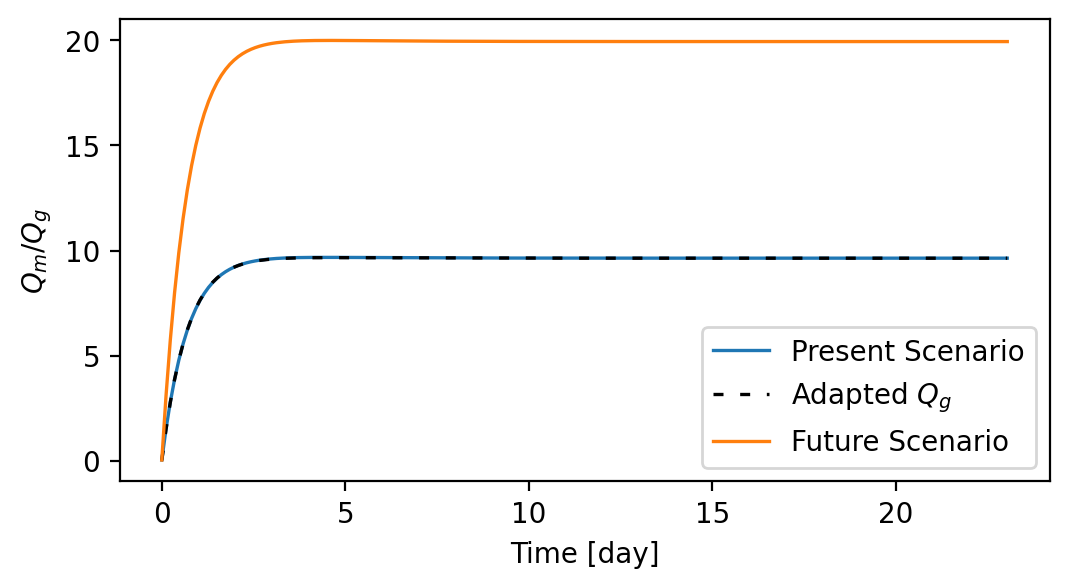

In [16]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
plt.plot(time, result['Q_m'] / Q_g, linewidth=1.2, label = 'Present Scenario')
plt.plot(time, adaptedQ_g['Q_m'] / 144.8, linewidth=1.2, label = 'Adapted $Q_g$', c = "k", linestyle =  (0, (3, 5)))
plt.plot(time, future['Q_m'] / Q_g, linewidth=1.2, label = 'Future Scenario')
plt.xlabel('Time [day]')
plt.ylabel('$Q_m/Q_g$')
plt.legend()

## Sensitivity Study

Out of the environmental parameters $T_a$, $S_a$, $Q_g$ and the average depth of the plume layer $z_b$, one is varied while the others remain constant to see how the model reacts to the change. The constant parameters are the ones used in the present scenario.

In [17]:
T_a = -1
S_a = 33
Q_g = 70
z_b = -300

For this case, the development of values during the loop are not relevant. The new function "sens_study" works just like "boxmodel" but only returns the last calculated value. This allows for arrays as input parameters.

In [18]:
def sens_study(S_a, T_a, Q_g, z_b): 
    S = 30 # starting value for the plume
    T = freeze(S, z_b)
    
    for i in range(N):
        # basal melting
        bmelt = basalmelting(S, T, z_b)
        S_b = bmelt["S_b"]
        T_b = bmelt["T_b"]
        v_b = bmelt["v_b"]
        Q_m = v_b * A
        
        # plume parameters
        Q = - (Q_g + Q_m + Q_a)
        S = (Q_a * S_a + V/dt * S) / (V/dt - Q)
        T = (Q_a * T_a + Q_g * T_g + (Q_m + A * gamma_T) * T_b + V/dt * T) / (V/dt - Q + A * gamma_T)
        
    return {
        "v_b": v_b * s_yr,
        "S": S,
        "T": T,
        "S_b": S_b,
        "T_b": T_b,
        "Q_m": Q_m,
        "Q_out": Q,
    }

### Varying the ambient water temperature $T_a$

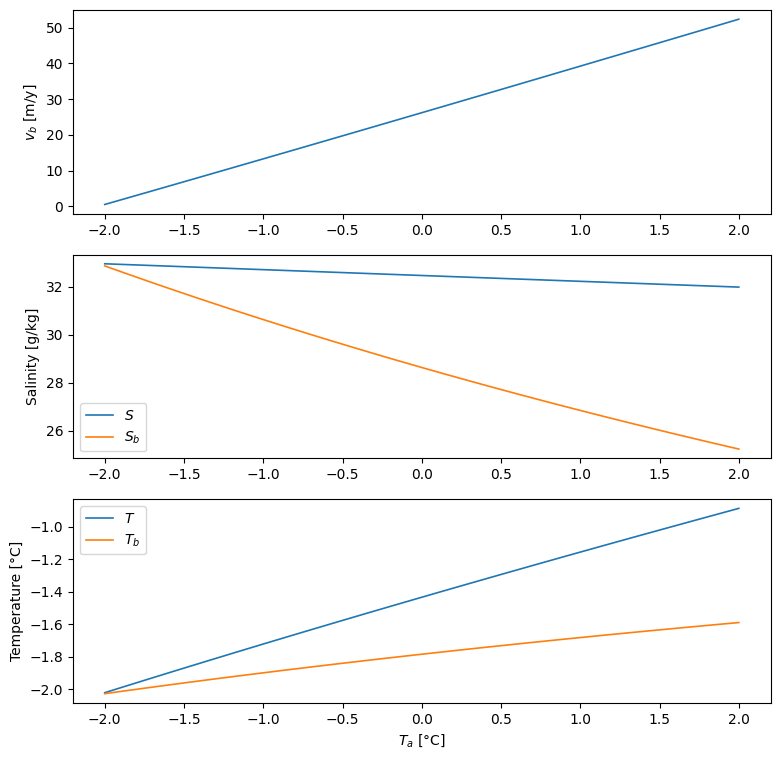

In [19]:
S_a = 33
Q_g = 70
z_b = -300
T_bot = -2
T_top = 2
T_a = np.linspace(T_bot, T_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(T_a, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$T_a$ [°C]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()

### Varying the ambient water salinity $S_a$

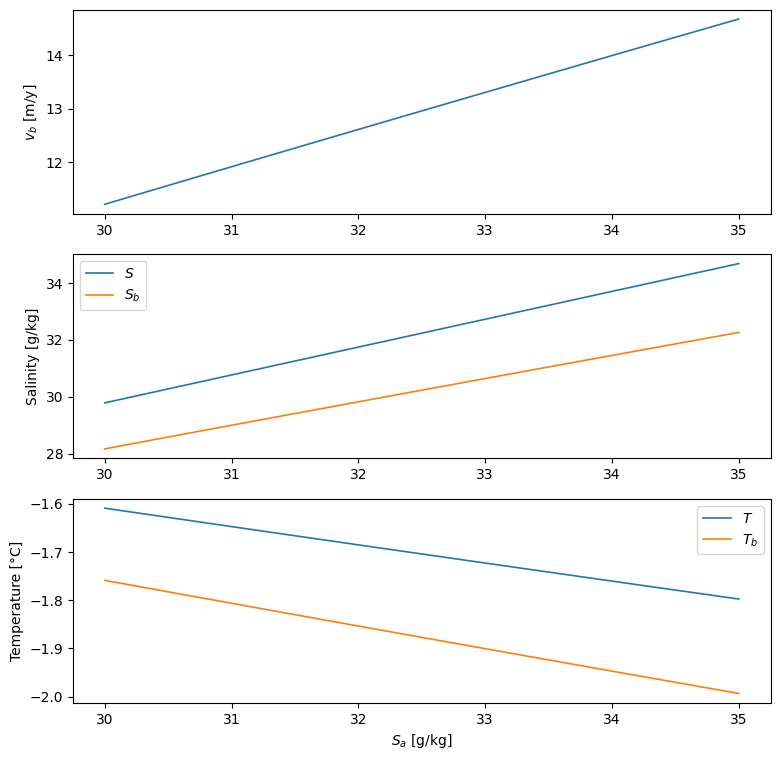

In [20]:
T_a = -1
Q_g = 70
z_b = -300
S_bot = 30
S_top = 35
S_a = np.linspace(S_bot, S_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(S_a, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$S_a$ [g/kg]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()

### Varying the transport from subglacial discharge $Q_g$

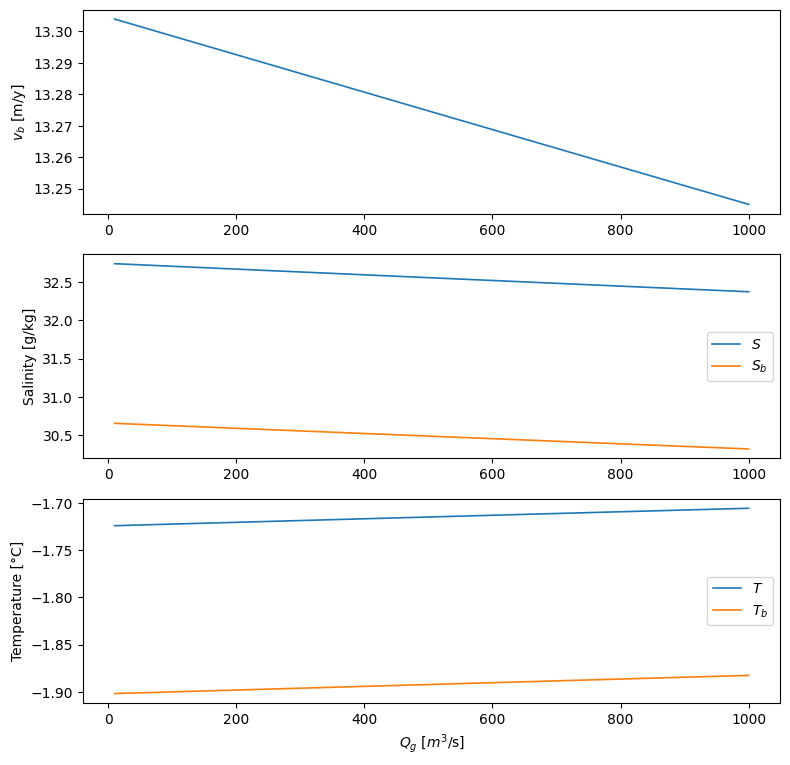

In [21]:
T_a = -1
S_a = 33
z_b = -300
Q_bot = 10
Q_top = 1000
Q_g = np.linspace(Q_bot, Q_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(Q_g, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].set_xlabel('$Q_g$ [$m^3$/s]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()

### Varying the average depth of the plume layer $z_b$

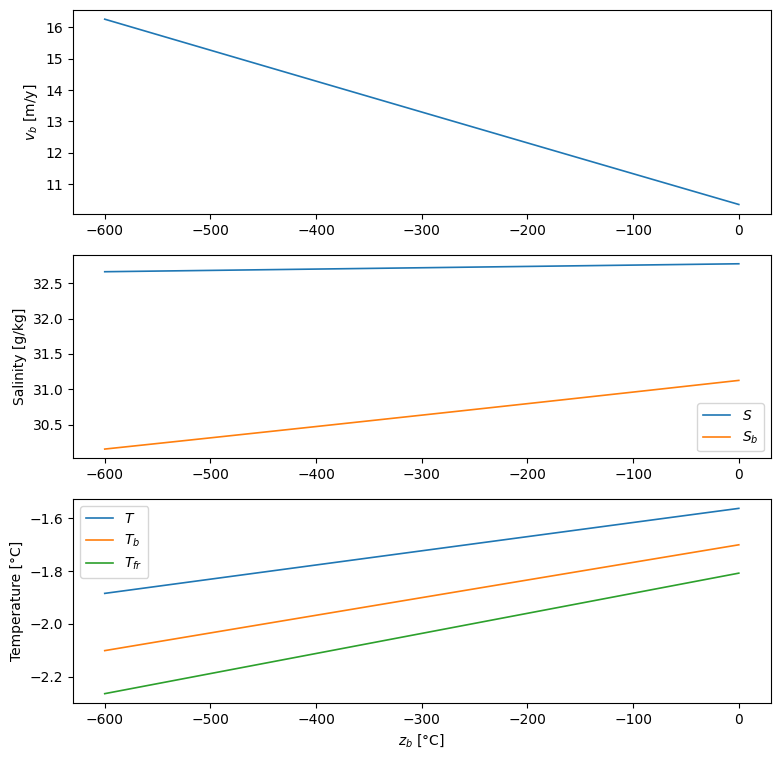

In [22]:
T_a = -1
S_a = 33
Q_g = 70
z_bot = -600
z_top = 0
z_b = np.linspace(z_bot, z_top, 100)
    
fig, axs = plt.subplots(3, figsize=(9,9))
axs[0].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["v_b"], linewidth=1.2)
axs[0].set_ylabel('$v_b$ [m/y]')
axs[1].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["S"], linewidth=1.2, label= '$S$')
axs[1].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["S_b"], linewidth=1.2, label= '$S_b$')
axs[1].set_ylabel('Salinity [g/kg]')
axs[1].legend()
axs[2].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["T"], linewidth=1.2, label= '$T$')
axs[2].plot(z_b, sens_study(S_a, T_a, Q_g, z_b)["T_b"], linewidth=1.2, label= '$T_b$')
axs[2].plot(z_b, y1*S_a+y2+y3*z_b, linewidth=1.2, label= '$T_{fr}$') # adding the freezing temperature
axs[2].set_xlabel('$z_b$ [°C]')
axs[2].set_ylabel('Temperature [°C]')
axs[2].legend()

## Varying multiple parameters

It is very unlikely that only one of the parameters will change so color maps are used to simulate a more realistic scenario where two parameters change. The most interesting ones are the temperature and salinity of the ambient water, the patter below can be adapted to any other combination however. To create the color maps, the function 'variation' is defined. X is the resolution of the colormap.

In [23]:
def variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, Quantity, X):
    colormap = np.zeros((X,X))
    for i in range(0, X):
        for k in range(0, X):
            salt = S_bot + i * (S_top - S_bot) / X
            temp = T_bot + k * (T_top - T_bot) / X
            if temp >= y1 * salt + y2 + y3 * z_b:
                colormap[i,k] = sens_study(salt, temp, Q_g, z_b)[Quantity]
            else:
                colormap[i,k] = np.nan
    return colormap.transpose()

In [24]:
S_bot = 30
S_top = 35
T_bot = -2
T_top = 2
Q_g = 70
z_b = -300
X = 200

Salinity = np.arange(S_bot, S_top + (S_top-S_bot) / X, (S_top-S_bot) / (X-1))
Freeze = y1 * Salinity + y2 + y3 * z_b
Temperature = np.arange(T_bot, T_top + (T_top-T_bot) / X, (T_top-T_bot) / (X-1))

The results can then be plotted using the 'cmocean' package

#### Melt rate $v_b$

In [25]:
v_b_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X)

Text(0, 0.5, '$T_a$ [°C]')

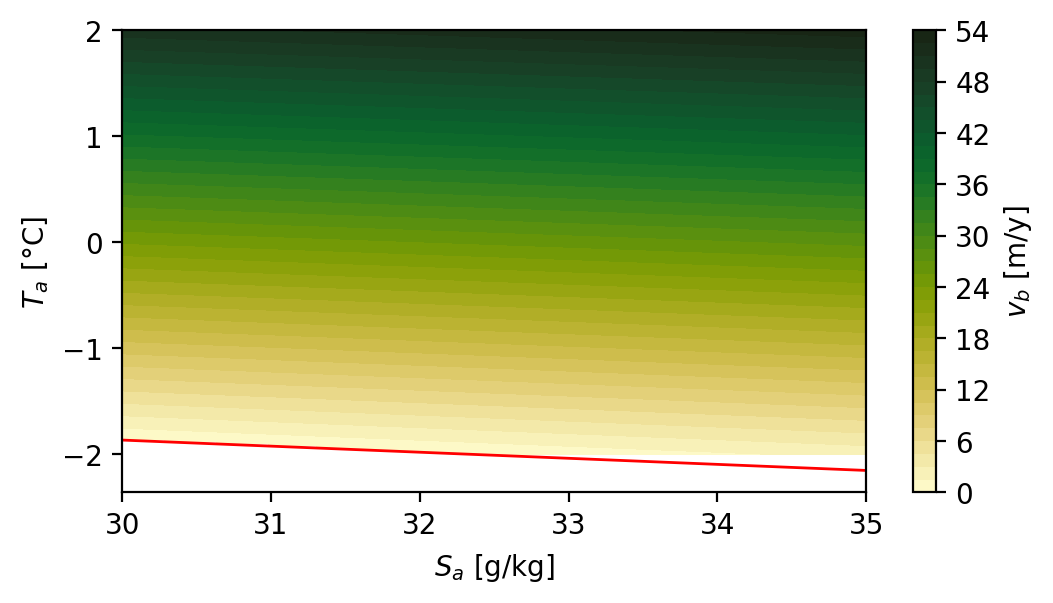

In [26]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, v_b_Ta_Sa,levels=40,cmap=cmocean.cm.speed)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Plume temperature $T$

In [27]:
T_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "T", X)

Text(0, 0.5, '$T_a$ [°C]')

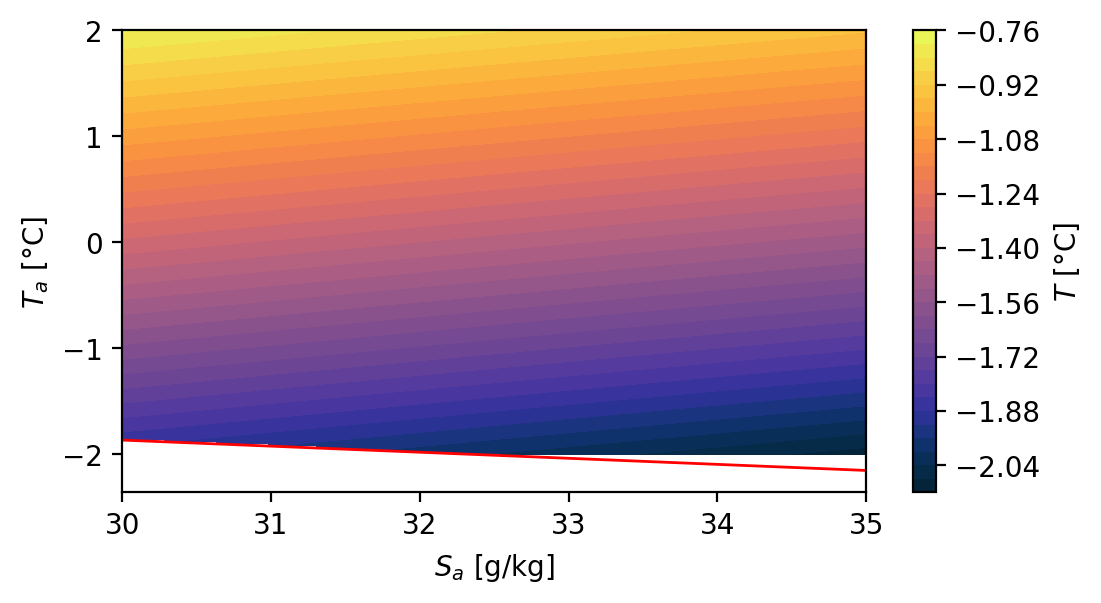

In [28]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, T_Ta_Sa,levels=40,cmap=cmocean.cm.thermal)
plt.colorbar(label = '$T$ [°C]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Melt layer temperature $T_b$

In [29]:
Tb_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "T_b", X)

Text(0, 0.5, '$T_a$ [°C]')

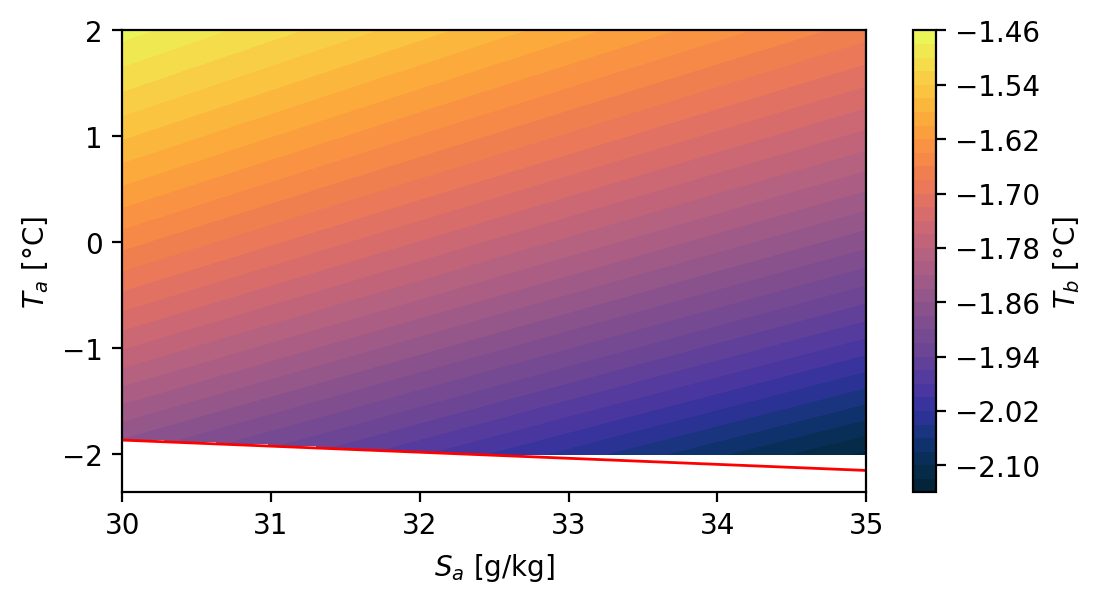

In [30]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, Tb_Ta_Sa,levels=40,cmap=cmocean.cm.thermal)
plt.colorbar(label = '$T_b$ [°C]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Plume salinity $S$

In [31]:
S_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "S", X)

Text(0, 0.5, '$T_a$ [°C]')

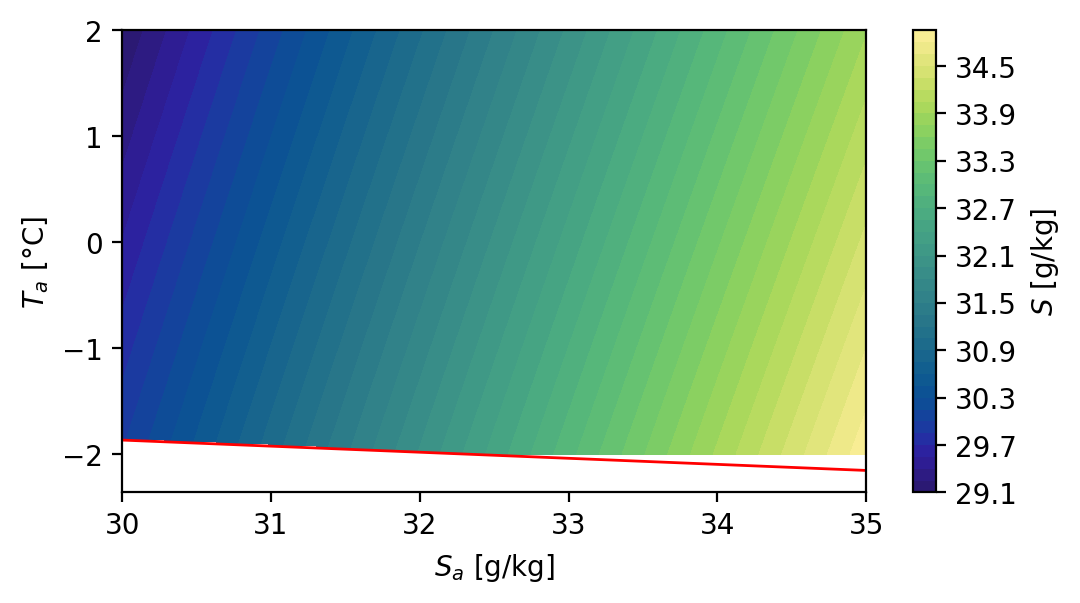

In [32]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, S_Ta_Sa,levels=40,cmap=cmocean.cm.haline)
plt.colorbar(label = '$S$ [g/kg]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Salinity melt layer $S_b$

In [33]:
Sb_Ta_Sa = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "S_b", X)

Text(0, 0.5, '$T_a$ [°C]')

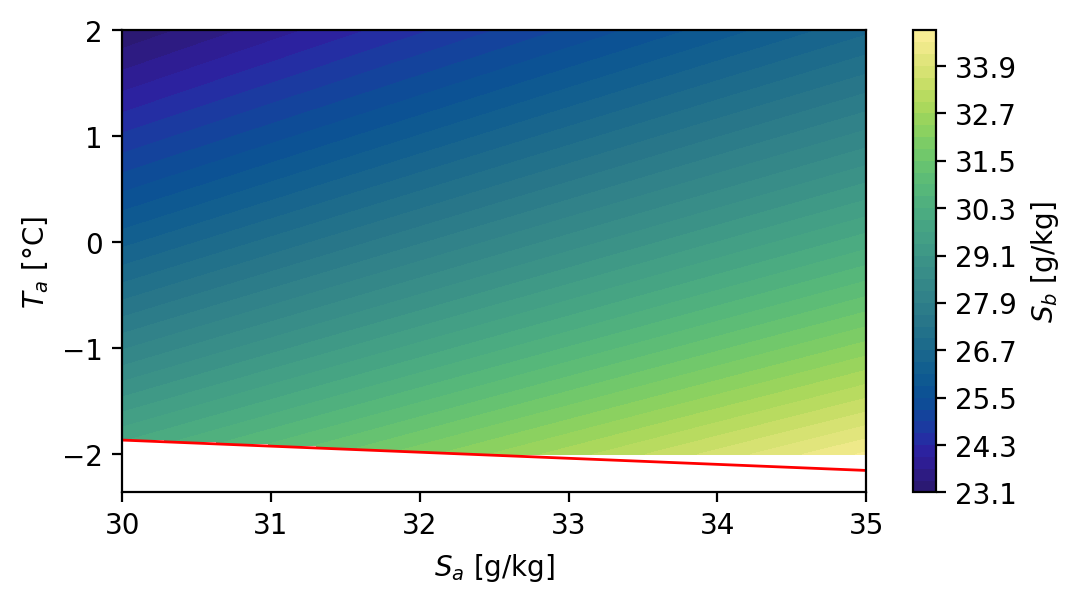

In [34]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, Sb_Ta_Sa,levels=40,cmap=cmocean.cm.haline)
plt.colorbar(label = '$S_b$ [g/kg]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Melt rate for changing $Q_g$

In [35]:
DeltaMR_Q = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X) - variation(S_bot, S_top, T_bot, T_top, 1000, z_b, "v_b", X)

Text(0, 0.5, '$T_a$ [°C]')

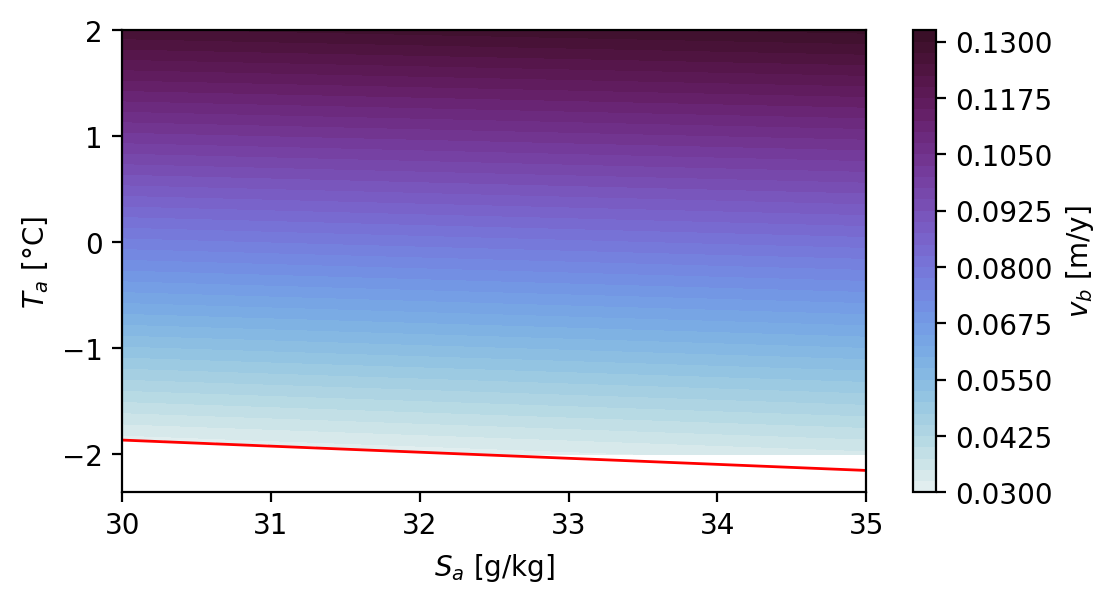

In [36]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, DeltaMR_Q, levels = 40, cmap=cmocean.cm.dense)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')

#### Melt rate for changing $z_b$

In [37]:
DeltaMR_z = variation(S_bot, S_top, T_bot, T_top, Q_g, z_b, "v_b", X) - variation(S_bot, S_top, T_bot, T_top, Q_g, -50, "v_b", X)

Text(0, 0.5, '$T_a$ [°C]')

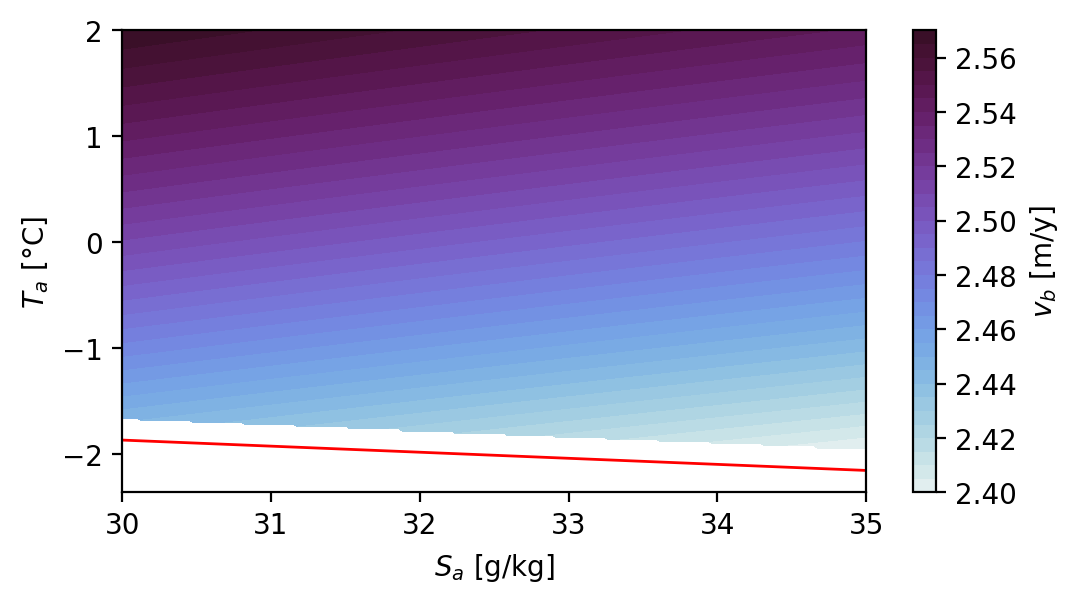

In [38]:
fig = plt.figure(figsize=(6,3), dpi= 200, facecolor='w', edgecolor='k')
im = plt.contourf(Salinity, Temperature, DeltaMR_z, levels = 40, cmap=cmocean.cm.dense)
plt.colorbar(label = '$v_b$ [m/y]')
plt.plot(Salinity, Freeze, color= 'red', linewidth = 1)
plt.xlabel('$S_a$ [g/kg]')
plt.ylabel('$T_a$ [°C]')